In [2]:
# 繪圖設定字體顏色(否則黑色會看不到)
import matplotlib as mpl
COLOR1 = 'red'
COLOR2 = 'blue'
mpl.rcParams['text.color'] = COLOR1
mpl.rcParams['axes.labelcolor'] = COLOR2
mpl.rcParams['xtick.color'] = COLOR2
mpl.rcParams['ytick.color'] = COLOR2

Loading images...
len(X) = 260 len(y) = 260
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
max_poolin

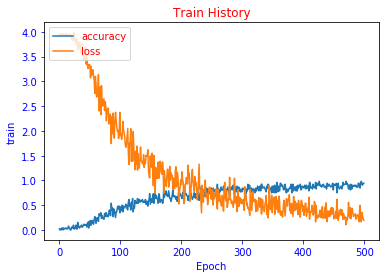

預測結果index = [ 0 29]
預測結果 = ['A', 'd']


In [3]:
# 用自己的手繪圖片辨識(A-Z)-skimage.io.imread()讀檔
    # 已經轉成0-1，白色1、黑色0
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from skimage import data, color, io
from skimage.transform import rescale, resize
import tensorflow as tf

# 讀取圖檔 + reshape + 黑白轉換
def ReadImageFile(filename):
    image1 = io.imread(filename, as_gray=True)
    image_resized = resize(image1, (28, 28), anti_aliasing=True)    
    X1 = image_resized.reshape(28, 28, 1) #/ 255
    return np.abs(1 - X1)

# 讀取資料夾內所有檔案(含次目錄)
IMAGE_DIRECTORY = './pic/a_z'
def load_data():
    print("Loading images...")
    X = []     # 存放 每個圖檔矩陣
    y = []     # 存放 數字結果label，注意元素是str
    for dirpath, dirnames, filenames in os.walk(IMAGE_DIRECTORY):
        for filename in [f for f in filenames if f.endswith(".png")]:
            y.append(filename[0])
            X.append(ReadImageFile(dirpath + '/' + filename)) # os.path.join(dirpath, filename)))
    return X, y

X, y = load_data()
print('len(X) =', len(X), 'len(y) =', len(y))

'''
# 資料量太少，不切割
X_train.shape, X_test.shape, y_train.shape, y_test.shape = (260, 28, 28, 1), (260, 28, 28, 1), (260,), (260,)
'''
X_train, X_test, y_train, y_test = np.array(X), np.array(X), np.array(y), np.array(y)

# one-hot encoding：shape=(260, 52)
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
# 物件轉array:.toarray()
y_TrainOneHot = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
y_TestOneHot = ohe.fit_transform(y_test.reshape(-1, 1)).toarray()

# 模型
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.25))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(52, activation='softmax'))
    # 編譯: 選擇損失函數、優化方法及成效衡量方式
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(model.summary())

# 訓練：產生一百批次圖片
epochs, batch_size = 500, 26
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
history = model.fit_generator(
    datagen.flow(X_train, y_TrainOneHot, batch_size=batch_size), 
    steps_per_epoch=2, epochs=epochs, verbose=0)

# 繪圖
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.xlabel('Epoch')
    plt.ylabel('train')
    plt.legend([train, validation], loc='upper left')
    plt.show()
show_train_history(history, 'accuracy', 'loss')

# 預測
X = []
X.append(ReadImageFile('./pic/testA.png'))
X.append(ReadImageFile('./pic/testd.png'))
# 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
import string
alphabet = string.ascii_uppercase + string.ascii_lowercase
print('預測結果index =', np.argmax(model.predict(np.array(X)), axis=-1))
print('預測結果 =', [alphabet[i] for i in model.predict_classes(np.array(X))])